### SSIoT traffic analysis

The notebook is designed to fit my data, but it should work for also for the other IoT device.
The pcap files should first be converted into a csv file.

In [2]:
import pandas as pd
import sys
from os import listdir
from os.path import isfile, join
import re
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from pandas.plotting import autocorrelation_plot
import numpy as np


In [3]:
path_miLamp = "C:\\Users\\Raphael\\github\\Security-Services-for-IoT\\Final-Project\\pcap\\processed\\csv-files\\"
path_smartPlug = "C:\\Users\\Raphael\\github\\Security-Services-for-IoT\\Final-Project\\pcap\\processed\\splug-csv\\"
filenames_miLamp = [f for f in listdir(path_miLamp) if isfile(join(path_miLamp, f))]
filenames_smartPlug = [f for f in listdir(path_smartPlug) if isfile(join(path_smartPlug, f))]

exclude= ["MiLampStartUp.csv", "MiLampStartUp2.csv"]

### Load files and label them accordinngly
Each csv file in the given directory, except the ones in the "exclude" variable, will be loaded and added to one dataframe. 
The labels correspond the the filename.

In [4]:
# read files and label them accordingly
def read_and_label(filenames,exclude, path):
    sametest = []
    checked = set()
    for file in filenames:
        if file in exclude:
            continue
        same = []
        file = file.split(".")[0]
        for name in filenames:
            if file in name and file != name:
                if name not in checked:
                    #name = name.split(".")[0]
                    same.append(name)
                    checked.add(name)
        if len(same) > 0:
            sametest.append(same)
    df = pd.DataFrame()
    for files in sametest:
        tm = pd.DataFrame()
        for i in range(len(files)):
            tm = pd.concat([tm, pd.read_csv(path + files[i], header=0)],ignore_index=False)
        tm["label"] = str(files[0].split(".")[0])
        df = pd.concat([df,tm], ignore_index=False)
    df = df.reset_index(drop=True)
    return df

### The recode_time might need to be changed depending on the format of the timestamp

In [5]:
# reformat the timestamp
def recode_time(df):
    for i in range(df.shape[0]):
        date = str(df.at[i,"frame.time"]).split(" ")
        if len(date) == 7:
            df.at[i,"frame.time"] = pd.Timestamp(str(df.at[i,"frame.time"]).split(" ")[4])
        else:
            df.at[i,"frame.time"] = pd.Timestamp(str(df.at[i,"frame.time"]).split(" ")[3])

In [6]:
# drop specific rows
def drop_it(df, column, value):
    df = df.drop(df[(df[column[0]] != value) | (df[column[1]] != value)].index)
    return df

In [7]:
# plots every feature of the given df, except the excluded ones, m are rows and n are the columns of the plot
def plot_stuff(df, exclude,m,n):
    c = 0
    r = 0
    fig, axs = plt.subplots(m,n, sharex=False, figsize=(30,12))
    for column in df:
        if column in exclude:
            continue
        axs[r, c%n] = df[column].value_counts().plot(kind="barh", ax=axs[r, c%n], title=column)
        #axs[r, c%n].set_title(column)
        # set individual bar lables using above list
        for i in axs[r, c%n].patches:
            # get_width pulls left or right; get_y pushes up or down
            axs[r, c%n].text(i.get_width()+.1, i.get_y()+.2, str(round((i.get_width()), 2)), fontsize=10, color='dimgrey')
        c += 1 
        r += n == c /(r + 1)
    plt.show()
    plt.clf
    print("Info for ip protocol: 2:{}, 6: {}, 17: {}".format("IGMP (Internet Group Management Protocol)", "TCP", "UDP"))

In [8]:
# plots the autocorrelation of a given df
def plot_autocorr(df):
    c = 0
    r = 0
    labels = df.label.value_counts().index.tolist()
    m = 4
    n = len(labels)//m +1
    fig, axs = plt.subplots(m,n, sharex=False, figsize=(30,12))
    for label in labels:
        axs[r, c%n] = autocorrelation_plot(df["data.len"].loc[df.label==label], ax=axs[r, c%n])
        axs[r, c%n].set_title(label)
        c += 1 
        r += n == c /(r + 1)
    plt.show()
    plt.clf

In [26]:
# plots the different data lengths and their occurence, Occurence should be computed before that
def plot_len_occ(df):
    c = 0
    r = 0
    labels = df.label.value_counts().index.tolist()
    m = 4
    n = len(labels)//m +1
    fig, axs = plt.subplots(m,n, sharex=False, figsize=(30,15))
    for label in labels:
        plot_label =  np.array(df["data.len"].loc[df.label==label].value_counts().index.tolist())
        data = []
        for val in plot_label:
            data.append(df["len_count"].loc[(df.label==label) & (df["data.len"] == val)].iloc[0])
        x = np.arange(len(plot_label))
        #if len(data) > len(plot_label):
            #data = data[0:len(plot_label)]
        #print(label)
        #print(data)
        #print(plot_label)
        axs[r, c%n].bar(x, data, 0.5)
        axs[r, c%n].set_title(label)
        axs[r, c%n].set_xticklabels(plot_label)
        axs[r, c%n].set_xticks(x)

        c += 1 
        r += n == c /(r + 1)
    plt.show()
    plt.clf

In [10]:
# Function to remove background traffic
# input df: dataframe which should be modified
# input relevant: list of relevant host IP addresses
def removeBack(df, relevant, mac):
  print("{} total flows".format(df.shape[0]))
  result = df.loc[(df["ip.src"] == relevant[0]) | (df["ip.dst"] == relevant[0])]
  for i in range(1,len(relevant)):
    result = pd.concat([result,df.loc[(df["ip.src"] == relevant[i]) | (df["ip.dst"] == relevant[i])]], ignore_index =True)
  result = pd.concat([result,df.loc[(df["eth.src"] == mac) | (df["eth.dst"] == mac)]], ignore_index =True)
  result = result.drop_duplicates()
  print("{} flows from relevant hosts".format(result.shape[0]))
  result = result.reset_index(drop=True)
  return result

In [11]:
df_ml = read_and_label(filenames_miLamp, exclude, path_miLamp)
df_sp = read_and_label(filenames_smartPlug, [], path_smartPlug)
recode_time(df_ml)

In [12]:
# show available labels for MiLamp:
df_ml.label.value_counts()

MiLampDecreaseBrightnessInApp    282
MiLampIncreaseTempInApp          229
MiLampDecreaseTempInApp          196
MiLampIncreaseBrightnessInApp    181
MiLampChildMode                   65
MiLampPushTurnButtonLeft          52
MiLampAdjustTempInApp             41
MiLampTurnButtonLeft              41
MiLampTurnButtonRight             36
MiLampTurnOnFocusModeApp          30
MiLampPushTurnButtonRight         27
MiLampDoubleTabButton             26
MiLampAdjustBrightnessInApp       24
MiLampOpenApp                     20
MiLampTurnOffinApp                15
MiLampTurnOninApp                 15
MiLampTurnOnPCModeApp             15
MiLampTurnOffFocusModeApp         14
MiLampTurnOnReadingModeApp        13
MiLampPressOnButtonToTurnOn       13
MiLampOpenSettings                11
MiLampPressOnButtonToTurnOff      10
Name: label, dtype: int64

In [13]:
# show available labels for SmartPlug:
df_sp.label.value_counts()

test_on_off_using_wifi                           852
plug_device                                      240
turn_of                                          233
whole_interaction_on_off_setti_sch_tim_aw_run    233
turn_on                                          197
leave_1_min_the_page_device                      155
leave_the_app_open_with_no_action                124
enter_to_the_app                                  57
set_off_away_mode                                 52
press_wifi_button                                 47
press_turn_off                                    45
go_to_settings_device                             44
create_schedule                                   40
set_away_mode                                     37
add_event                                         32
enter_to_the_device_from_app                      25
enter_to_run_time                                 24
press_turn_on                                     19
Name: label, dtype: int64

In [14]:
df_sp.tail()

,frame.number,frame.time,eth.src,eth.dst,ip.src,ip.dst,ip.proto,data.data,data.len,udp.srcport,udp.dstport,udp.length,eth.addr.oui_resolved,tcp.srcport,tcp.dstport,tcp.len,label
2451,229,"Jun 8, 2020 09:53:07.169555000 Mitteleuropäis...",98:0d:67:33:29:70,d0:37:45:53:9a:9d,81.161.59.87,192.168.1.182,6.0,NaN,NaN,NaN,NaN,NaN,"Tp-Link Technologies Co.,Ltd.",80.0,51050.0,279.0,whole_interaction_on_off_setti_sch_tim_aw_run
2452,230,"Jun 8, 2020 09:53:07.169603000 Mitteleuropäis...",d0:37:45:53:9a:9d,98:0d:67:33:29:70,192.168.1.182,81.161.59.87,6.0,NaN,NaN,NaN,NaN,NaN,Zyxel Communications Corporation,51050.0,80.0,0.0,whole_interaction_on_off_setti_sch_tim_aw_run
2453,231,"Jun 8, 2020 09:53:07.172674000 Mitteleuropäis...",d0:37:45:53:9a:9d,98:0d:67:33:29:70,192.168.1.182,81.161.59.87,6.0,NaN,NaN,NaN,NaN,NaN,Zyxel Communications Corporation,51050.0,80.0,95.0,whole_interaction_on_off_setti_sch_tim_aw_run
2454,232,"Jun 8, 2020 09:53:07.221139000 Mitteleuropäis...",98:0d:67:33:29:70,d0:37:45:53:9a:9d,81.161.59.87,192.168.1.182,6.0,NaN,NaN,NaN,NaN,NaN,"Tp-Link Technologies Co.,Ltd.",80.0,51050.0,0.0,whole_interaction_on_off_setti_sch_tim_aw_run
2455,233,"Jun 8, 2020 09:53:07.454326000 Mitteleuropäis...",cc:2d:b7:bf:3b:e0,01:00:5e:00:00:fb,192.168.1.57,224.0.0.251,17.0,NaN,NaN,5353.0,5353.0,69.0,"Apple, Inc.",NaN,NaN,NaN,whole_interaction_on_off_setti_sch_tim_aw_run


In [15]:
df_ml.tail()

,frame.number,frame.time,eth.src,eth.dst,ip.src,ip.dst,ip.proto,data.data,data.len,udp.srcport,udp.dstport,udp.length,eth.addr.oui_resolved,tcp.srcport,tcp.dstport,tcp.len,label
1351,4,2020-06-18 10:29:24.891892,46:85:00:12:35:54,40:31:3c:d3:23:d4,18.197.235.166,192.168.137.44,17.0,21310040000000000721ae555ee5dfe24a87628415f7eb...,64.0,8053.0,54321.0,72.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,MiLampTurnOnReadingModeApp
1352,1,2020-06-18 10:30:25.712641,46:85:00:12:35:54,40:31:3c:d3:23:d4,18.197.235.166,192.168.137.44,17.0,21310070000000000721ae555ee5e01e69bd7a8103f808...,112.0,8053.0,54321.0,120.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,MiLampTurnOnReadingModeApp
1353,2,2020-06-18 10:30:25.989177,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.44,18.197.235.166,17.0,21310040000000000721ae555ee5e01fc6d6d4d06711fe...,64.0,54321.0,8053.0,72.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,MiLampTurnOnReadingModeApp
1354,3,2020-06-18 10:30:25.999532,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.44,18.197.235.166,17.0,21310070000000000721ae555ee5e01fd45c88814c42b5...,112.0,54321.0,8053.0,120.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,MiLampTurnOnReadingModeApp
1355,4,2020-06-18 10:30:26.026244,46:85:00:12:35:54,40:31:3c:d3:23:d4,18.197.235.166,192.168.137.44,17.0,21310040000000000721ae555ee5e01f58e849ab5c31e6...,64.0,8053.0,54321.0,72.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,MiLampTurnOnReadingModeApp


### Clean the data from unwanted traffic


In [16]:
lampIps = ["192.168.137.44", "192.168.137.47"]
lampMac = "40:31:3c:d3:23:d4"
plugIps = "192.168.1.16"
plugMac = "1c:3b:f3:4d:36:04"

In [17]:
# only keep traffic from and to the IP addresses
df_sp = removeBack(df_sp,plugIps,plugMac)
df_ml = removeBack(df_ml,lampIps,lampMac)

2456 total flows
9 flows from relevant hosts
1356 total flows
1235 flows from relevant hosts


In [18]:
#df_ml["ip.src"].isnull().values.any()

### Plot the features

TypeError: no numeric data to plot

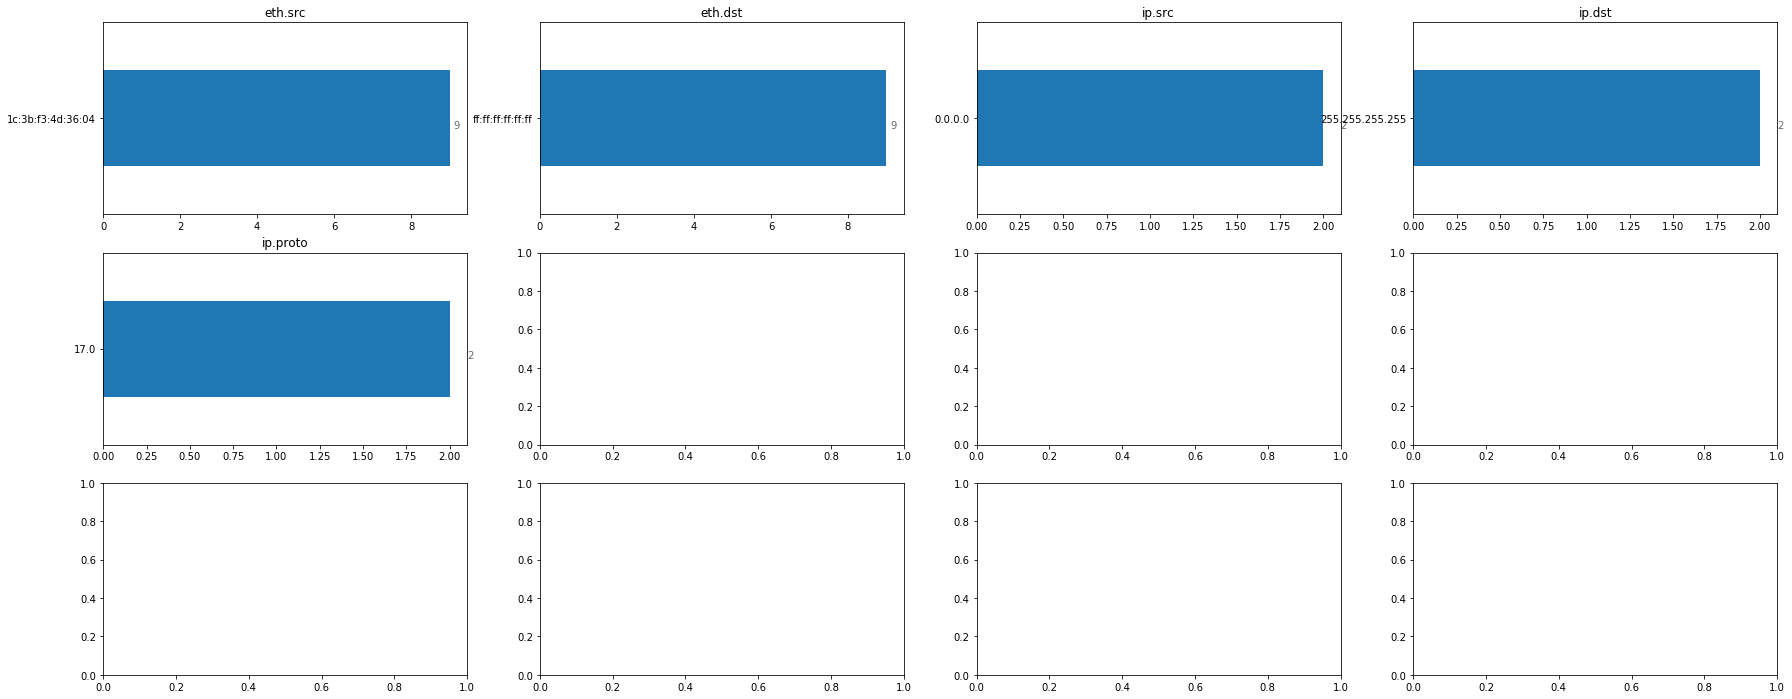

In [19]:
#features to exclude
no_interest = ["frame.number", "frame.time","data.data", "eth.addr.oui_resolved", "label"]
#plot smartplug
plot_stuff(df_sp,no_interest,3,4)

IndexError: index 3 is out of bounds for axis 0 with size 3

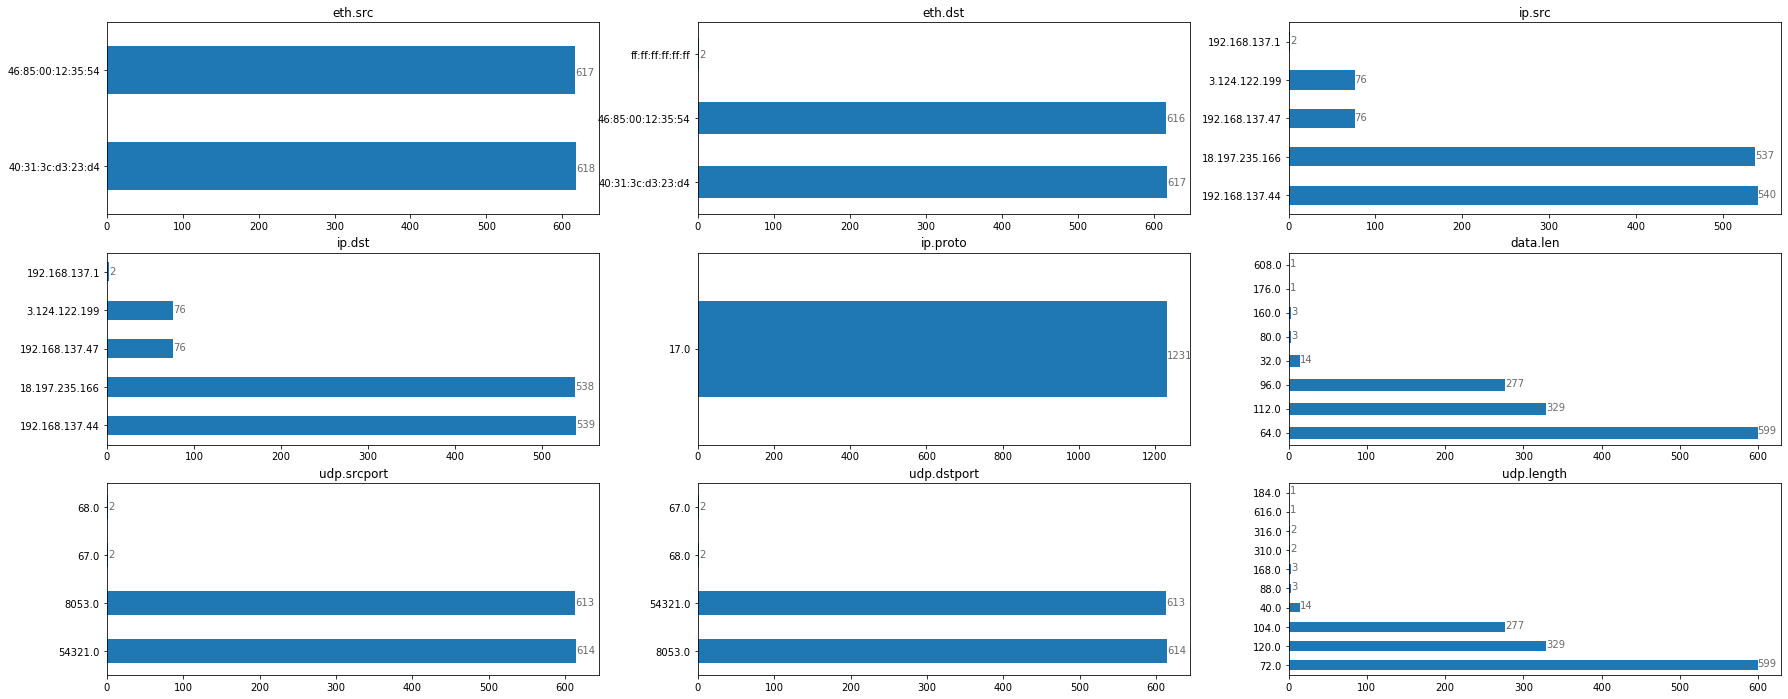

In [20]:
#plot Mi Lamp
plot_stuff(df_ml,no_interest,3,3)

In [43]:
lendata = df_ml["udp.length"].groupby(df_ml["label"]).value_counts()#.plot(kind="barh", figsize=(5,12)

In [23]:
# calculate the occurence of each packet data length of a measurement as a ration of its occurence/total number of packets of in a measurement
df_ml["len_count"] = 0
available_labels = df_ml["label"].value_counts().index.tolist()
for label in available_labels:
    available_lens = df_ml.loc[df_ml["label"] == label]["data.len"].value_counts().index.tolist()
    for length in available_lens:
        l = df_ml["data.len"].loc[(df_ml["label"] == label) & (df_ml["data.len"] == length)]
        df_ml["len_count"].loc[(df_ml["label"] == label) & (df_ml["data.len"] == length)] = l.shape[0]
    df_ml["len_count"].loc[(df_ml["label"] == label)] = df_ml["len_count"].loc[(df_ml["label"] == label)] / df_ml.loc[(df_ml["label"] == label)].shape[0]

C:\Users\Raphael\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


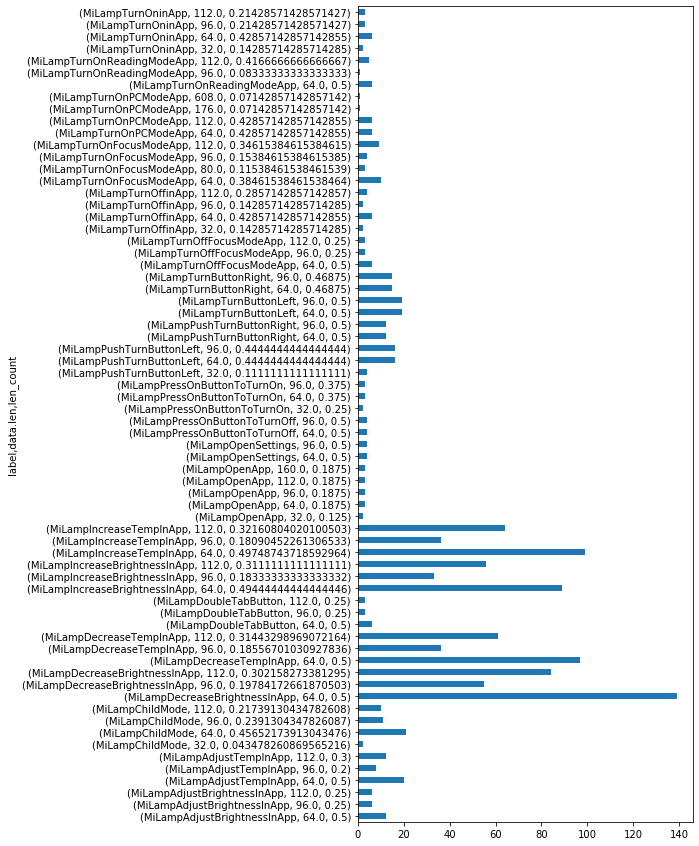

In [24]:
#plot variant 1
df_ml["len_count"].groupby([df_ml["label"], df_ml["data.len"]]).value_counts().plot(kind="barh", figsize=(6,15))
plt.show()

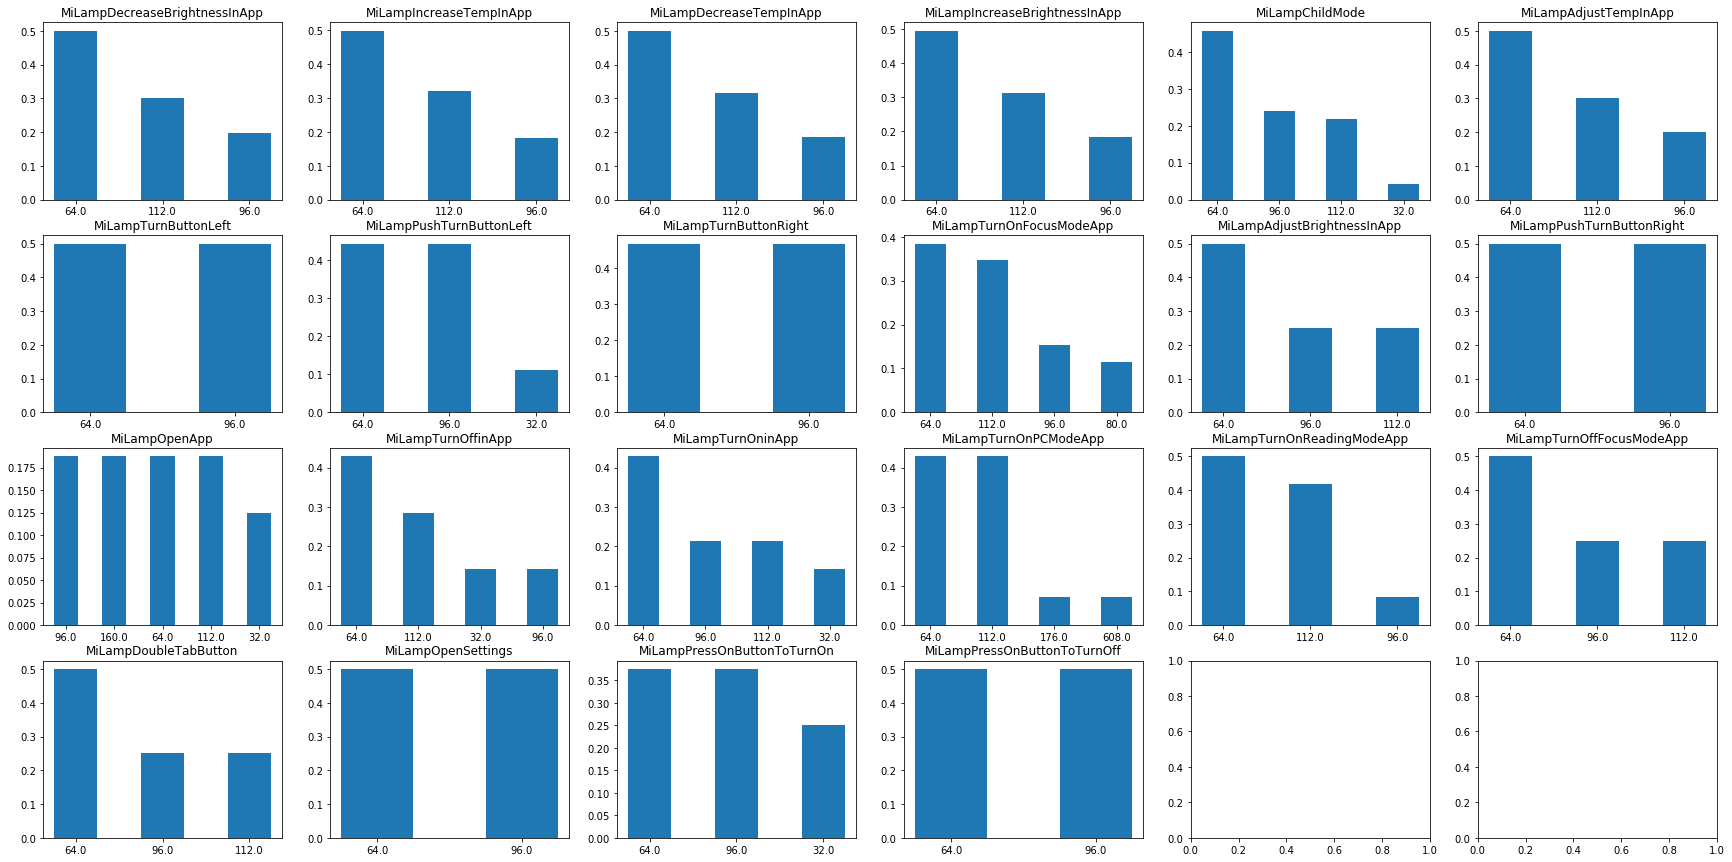

In [27]:
#plot variant 2
plot_len_occ(df_ml)

In [117]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier


In [126]:
x = df_ml.drop(columns=["frame.number", 'eth.addr.oui_resolved', "frame.time", "ip.proto"])
x = x.fillna("0")
#Function to encode given features
# input df: dataframe which should be modified
# input features: features that should be encoded
def encode_feature(df, feature):
  feature_enc = LabelEncoder()
  feature_enc.fit(df[feature].to_numpy().astype(str))
  df[feature] = feature_enc.transform(df[feature])

features = ["eth.src", "eth.dst", "ip.src", "ip.dst", "label", "data.data"]

for feat in features:
    encode_feature(x,feat)
y = x["label"]
x = x.drop(columns=["label"])
#x=x["data.data"]
x = x.reset_index(drop=True)

In [127]:
x.head()

,eth.src,eth.dst,ip.src,ip.dst,data.data,data.len,udp.srcport,udp.dstport,udp.length,tcp.srcport,tcp.dstport,tcp.len,len_count
0,0,1,3,1,6,32,54321,8053,40,0,0,0,0.043478
1,1,0,1,3,6,32,8053,54321,40,0,0,0,0.043478
2,1,0,1,3,1206,112,8053,54321,120,0,0,0,0.217391
3,0,1,3,1,587,64,54321,8053,72,0,0,0,0.456522
4,1,0,1,3,1207,112,8053,54321,120,0,0,0,0.217391


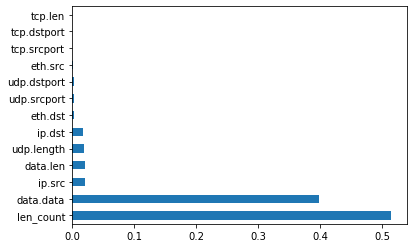

In [128]:
# Show the relevance of each feature
model = ExtraTreesClassifier()
model.fit(x,y.astype('int').ravel())
# visualize the importance of the features
imp_features = pd.Series(model.feature_importances_, index=x.columns)
imp_features.nlargest(len(x.columns.tolist())).plot(kind='barh')
plt.show()

In [141]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [142]:
# set up the classifier
# white-box classifier
model_wb = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)

prob_wb = model_wb.predict_proba(X_train)
print(model_wb.score(X_test,y_test))

# train black-box
model_bb = ComplementNB().fit(X_train,y_train)
prob_bb = model_bb.predict_proba(X_train)

print(model_bb.score(X_test,y_test))

0.875
0.12990196078431374
